In [1]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem.porter import PorterStemmer

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
POS_COLOR, NEG_COLOR, NEU_COLOR = '#38C477','#F2543D','#EEEEEE'
STOP_WORDS = set(stopwords.words('english'))

### Data

In [3]:
# Read the data
train_df = pd.read_csv("Corona_NLP_train.csv", encoding='latin1')
test_df = pd.read_csv("Corona_NLP_test.csv", encoding='latin1')

train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [4]:
train_df.dtypes

UserName          int64
ScreenName        int64
Location         object
TweetAt          object
OriginalTweet    object
Sentiment        object
dtype: object

In [5]:
train_df['OriginalTweet'] = train_df['OriginalTweet'].astype(str)
train_df['Sentiment'] = train_df['Sentiment'].astype(str)

test_df['OriginalTweet'] = test_df['OriginalTweet'].astype(str)
test_df['Sentiment'] = test_df['Sentiment'].astype(str)

# Remove unwanted columns
remove_cols = ['UserName', 'ScreenName', 'Location', 'TweetAt']
train_df.drop(remove_cols, axis=1, inplace=True)
test_df.drop(remove_cols, axis=1, inplace=True)

train_df.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [6]:
print('Number of rows in training: {}'.format(train_df.shape[0]))
print('Number of rows in test: {}'.format(test_df.shape[0]))

Number of rows in training: 41157
Number of rows in test: 3798


In [7]:
# Label values
train_df.Sentiment.unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

In [8]:
train_df.Sentiment.value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

Text(0.5, 1.0, 'Test Label Distribution')

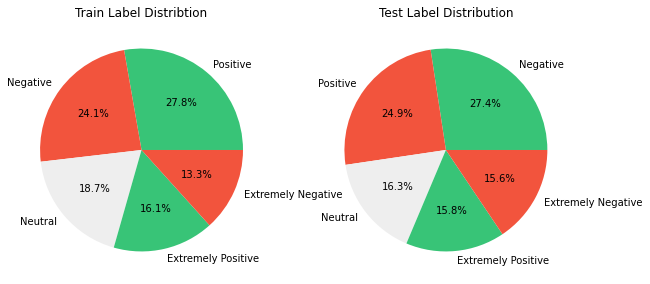

In [9]:
train_label_counts = train_df['Sentiment'].value_counts().to_dict()
test_label_counts = test_df['Sentiment'].value_counts().to_dict()

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10)) 

ax1.pie(train_label_counts.values(), labels=train_label_counts.keys(), colors = [POS_COLOR, NEG_COLOR, NEU_COLOR], autopct = '%1.1f%%')
ax1.set_title('Train Label Distribtion')

ax2.pie(test_label_counts.values(), labels = test_label_counts.keys(), colors = [POS_COLOR, NEG_COLOR, NEU_COLOR], autopct = '%1.1f%%')
ax2.set_title('Test Label Distribution')

In [10]:
# Combine positive and extermely positive classes, and negative and extremely negative classes
def combine_classes(x):
    if x in ["Extremely Positive", "Positive"]:
        return "Positive"
    elif x in ["Extremely Negative", "Negative"]:
        return "Negative"
    else:
        return "Neutral"
    
train_df['Sentiment'] = train_df['Sentiment'].apply(lambda x:combine_classes(x))
test_df['Sentiment'] = test_df['Sentiment'].apply(lambda x:combine_classes(x))

In [11]:
train_df.Sentiment.unique()

array(['Neutral', 'Positive', 'Negative'], dtype=object)

Text(0.5, 1.0, 'Test Label Distribution')

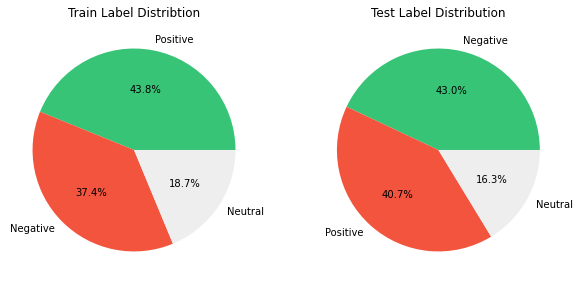

In [12]:
train_label_counts = train_df['Sentiment'].value_counts().to_dict()
test_label_counts = test_df['Sentiment'].value_counts().to_dict()

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10)) 

ax1.pie(train_label_counts.values(), labels=train_label_counts.keys(), colors = [POS_COLOR, NEG_COLOR, NEU_COLOR], autopct = '%1.1f%%')
ax1.set_title('Train Label Distribtion')

ax2.pie(test_label_counts.values(), labels = test_label_counts.keys(), colors = [POS_COLOR, NEG_COLOR, NEU_COLOR], autopct = '%1.1f%%')
ax2.set_title('Test Label Distribution')

In [13]:
def preprocessing(text):
    text = text.lower()
    
    # Remove URLs and HTML links
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove punctuations
    text = re.sub(r"[^\w\s\d]","", text)
    
    # Remove mentions
    text = re.sub(r'@\w+','', text)
    
    # Remove hashtags
    text = re.sub(r'#\w+','', text)
    
    # Remove whitepsaces
    text = re.sub(r"\s+"," ",text).strip()
    
    # Remove stopwords
    text = text.split()
    text = " ".join([word for word in text if not word in STOP_WORDS])
    
    # Stemming
    my_tokens = text.split()
    porter = PorterStemmer()
    stemmed_tokens = []
    for token in my_tokens:
        if len(token) > 2:
            stemmed_tokens.append(porter.stem(token))

    text = " ".join(stemmed_tokens)
    
    return text

train_df['OriginalTweet'] = train_df['OriginalTweet'].apply(lambda x: preprocessing(x))

In [14]:
train_df['Count'] = train_df['OriginalTweet'].str.split().str.len()
max_len = round(train_df['Count'].mean())
print("Average Tweet Length: ", max_len)

Average Tweet Length:  18


In [15]:
pos_df = train_df[train_df["Sentiment"] == "Positive"]
neg_df = train_df[train_df["Sentiment"] == "Negative"]
neu_df = train_df[train_df["Sentiment"] == "Neutral"]

pos_df['Count'] = pos_df['OriginalTweet'].str.split().str.len()
neg_df['Count'] = neg_df['OriginalTweet'].str.split().str.len()
neu_df['Count'] = neu_df['OriginalTweet'].str.split().str.len()

pos_count, neg_count, neu_count = pos_df['Count'].mean(), neg_df['Count'].mean(), neu_df['Count'].mean()

<ipython-input-15-f76a34e7a913>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_df['Count'] = pos_df['OriginalTweet'].str.split().str.len()
<ipython-input-15-f76a34e7a913>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_df['Count'] = neg_df['OriginalTweet'].str.split().str.len()
<ipython-input-15-f76a34e7a913>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [16]:
print(pos_count, neu_count, neg_count)

18.701429679707413 13.69117075068067 18.482270424730483


<BarContainer object of 3 artists>

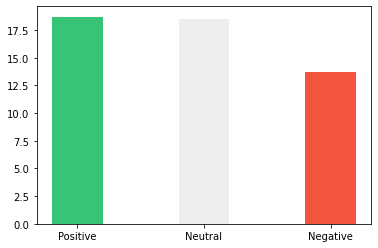

In [17]:
# Average number of words in a tweet for each class
plt.bar(['Positive', 'Neutral', 'Negative'], [pos_count, neg_count, neu_count], color = [POS_COLOR, NEU_COLOR, NEG_COLOR],
        width = 0.4)

In [18]:
pos_wc = WordCloud(background_color="white", colormap="Greens").generate(' '.join(pos_df['OriginalTweet']))
neg_wc = WordCloud(background_color="white", colormap="Reds").generate(' '.join(neg_df['OriginalTweet']))
neu_wc = WordCloud(background_color="white", colormap="Greys").generate(' '.join(neu_df['OriginalTweet']))

Text(0.5, 1.0, 'Negative')

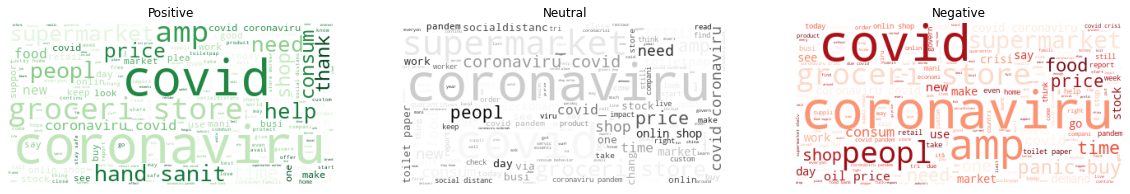

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,20)) 

ax1.imshow(pos_wc)
ax1.axis("off")
ax1.set_title("Positive")

ax2.imshow(neu_wc)
ax2.axis("off")
ax2.set_title("Neutral")

ax3.imshow(neg_wc)
ax3.axis("off")
ax3.set_title("Negative")

In [20]:
label_dict = {"Positive": 0, "Neutral": 1, "Negative": 2}
train_df['Sentiment'] = train_df['Sentiment'].map(label_dict)
test_df['Sentiment']  = test_df['Sentiment'].map(label_dict)

X_train, Y_train = train_df["OriginalTweet"], train_df["Sentiment"]
X_test, Y_test = test_df["OriginalTweet"], test_df["Sentiment"]

### Count Vectorizer

In [21]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [22]:
CV = CountVectorizer(max_features=4000)

train_CV = CV.fit_transform(X_train)
test_CV = CV.transform(X_test)

In [23]:
# Naives Bayes 
classifier = GaussianNB().fit(train_CV.toarray(), Y_train)
print("Train Accuracy: ", classifier.score(train_CV.toarray(), Y_train))
print("Test Accuracy: ", classifier.score(test_CV.toarray(), Y_test))

Train Accuracy:  0.49580873241489903
Test Accuracy:  0.33912585571353343


In [24]:
# Logistic Regression
classifier = LogisticRegression(random_state=0).fit(train_CV, Y_train)
print("Train Accuracy: ", classifier.score(train_CV, Y_train))
print("Test Accuracy: ", classifier.score(test_CV, Y_test))

Train Accuracy:  0.8726097626163228
Test Accuracy:  0.6648235913638757


C:\Users\vivek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [25]:
# Decision Tree
classifier = DecisionTreeClassifier(random_state=0).fit(train_CV, Y_train)
print("Train Accuracy: ", classifier.score(train_CV, Y_train))
print("Test Accuracy: ", classifier.score(test_CV, Y_test))

Train Accuracy:  0.9993682727118108
Test Accuracy:  0.5587151132174829


In [26]:
# Random Forest
classifier = RandomForestClassifier(random_state=0).fit(train_CV, Y_train)
print("Train Accuracy: ", classifier.score(train_CV, Y_train))
print("Test Accuracy: ", classifier.score(test_CV, Y_test))

Train Accuracy:  0.9993682727118108
Test Accuracy:  0.6324381253291206


In [27]:
# MLP
classifier = MLPClassifier(hidden_layer_sizes=(10,), random_state=0).fit(train_CV, Y_train)
print("Train Accuracy: ", classifier.score(train_CV, Y_train))
print("Test Accuracy: ", classifier.score(test_CV, Y_test))

Train Accuracy:  0.9985421677964866
Test Accuracy:  0.6182201158504476


### TFIDF

In [28]:
tfIdf =TfidfVectorizer(max_features=4000)

train_tfIdf = tfIdf.fit_transform(X_train)
test_tfIdf = tfIdf.transform(X_test)

In [29]:
# Naive Bayes
classifier = GaussianNB().fit(train_tfIdf.toarray(), Y_train)
print("Train Accuracy: ", classifier.score(train_tfIdf.toarray(), Y_train))
print("Test Accuracy: ", classifier.score(test_tfIdf.toarray(), Y_test))

Train Accuracy:  0.4744271934300362
Test Accuracy:  0.3417588204318062


In [30]:
# Logistic Regression
classifier = LogisticRegression(random_state=0).fit(train_tfIdf, Y_train)
print("Train Accuracy: ", classifier.score(train_tfIdf, Y_train))
print("Test Accuracy: ", classifier.score(test_tfIdf, Y_test))

Train Accuracy:  0.8506693879534466
Test Accuracy:  0.6777251184834123


C:\Users\vivek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [31]:
# Decision Tree
classifier = DecisionTreeClassifier(random_state=0).fit(train_tfIdf, Y_train)
print("Train Accuracy: ", classifier.score(train_tfIdf, Y_train))
print("Test Accuracy: ", classifier.score(test_tfIdf, Y_test))

Train Accuracy:  0.999343975508419
Test Accuracy:  0.5721432332806741


In [32]:
# Random Forest
classifier = RandomForestClassifier(random_state=0).fit(train_tfIdf, Y_train)
print("Train Accuracy: ", classifier.score(train_tfIdf, Y_train))
print("Test Accuracy: ", classifier.score(test_tfIdf, Y_test))

Train Accuracy:  0.999343975508419
Test Accuracy:  0.6237493417588205


In [33]:
# MLP
classifier = MLPClassifier(hidden_layer_sizes=(10,), random_state=0).fit(train_CV, Y_train)
print("Train Accuracy: ", classifier.score(train_tfIdf, Y_train))
print("Test Accuracy: ", classifier.score(test_tfIdf, Y_test))

Train Accuracy:  0.84814247880069
Test Accuracy:  0.564507635597683
